In [9]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [8]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 32.7 MB/s eta 0:00:00


In [10]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [12]:
import zipfile
import os

with zipfile.ZipFile('/content/archive (5).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data')  # Extracts the files to 'destination_folder'

# List extracted files (optional)
#os.listdir('destination_folder')


In [13]:
dir0='/content/sample_data/Apparel images dataset new'
dataset0=datasets.ImageFolder(root=dir0,transform=None)

class_names=dataset0.classes
print(class_names)
print(len(class_names))

['black_dress', 'black_pants', 'black_shirt', 'black_shoes', 'black_shorts', 'blue_dress', 'blue_pants', 'blue_shirt', 'blue_shoes', 'blue_shorts']
10


In [14]:
class DataModule(pl.LightningDataModule):

    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = dir0
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])
        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset

In [16]:
class ConvolutionalNetwork(LightningModule):

    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [21]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork()
    trainer = pl.Trainer(max_epochs=15)
    trainer.fit(model, datamodule)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | conv1 | Conv2d | 168    | train
1 | conv2 | Conv2d | 880    | train
2 | fc1   | Linear | 5.6 M  | train
3 | fc2   | Linear | 10.2 K | train
4 | fc3   | Linear | 1.7 K  | train
5 | fc4   | Linear | 210    | train
-----------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.448    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=14-step=2250.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=14-step=2250.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9249374270439148     │
│         test_loss         │    0.23511676490306854    │
└───────────────────────────┴───────────────────────────┘

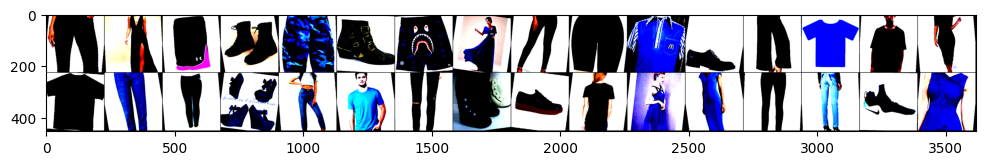

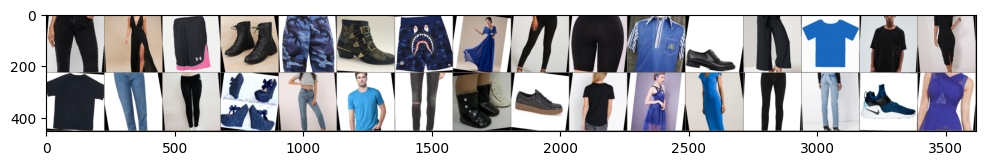

In [22]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [23]:
device = torch.device("cpu")   #"cuda:0"

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

              precision    recall  f1-score   support

 black_dress     0.8765    0.9103    0.8931        78
 black_pants     0.9585    0.9487    0.9536       195
 black_shirt     0.9597    0.9297    0.9444       128
 black_shoes     0.8839    0.9448    0.9133       145
black_shorts     0.9012    0.8902    0.8957        82
  blue_dress     0.9390    0.9506    0.9448        81
  blue_pants     0.9191    0.9521    0.9353       167
  blue_shirt     0.9542    0.9605    0.9574       152
  blue_shoes     0.9065    0.9065    0.9065       107
 blue_shorts     0.9400    0.7344    0.8246        64

    accuracy                         0.9266      1199
   macro avg     0.9239    0.9128    0.9169      1199
weighted avg     0.9274    0.9266    0.9261      1199



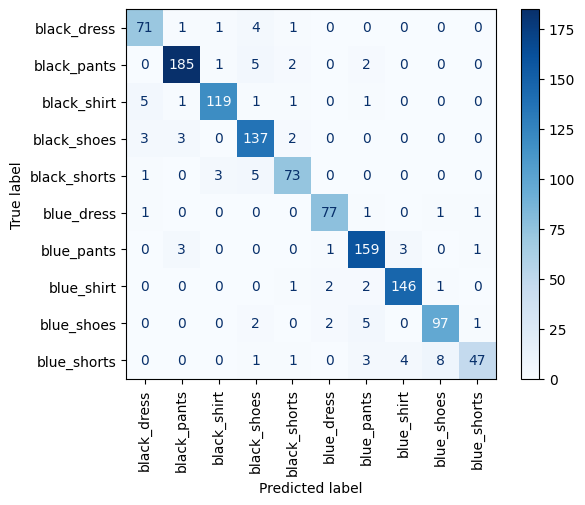

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()